**setup, cleaning awal, dan selection**

kode ini berfungsi sebagai inisialisasi dan tahap data selection.

1. inisialisasi: semua library penting (pandas, numpy, sklearn, matplotlib) di-import untuk seluruh proses preprocessing.

2. data loading & cleaning awal: file data crx.data dimuat ke dalam dataframe. saat pemuatan, saya langsung menerapkan pembersihan awal dengan menginstruksikan pandas (na_values=['?']) untuk mengubah semua karakter ? (nilai hilang/kotor) menjadi nan (nilai numerik yang dapat diproses).

3. data selection: data kemudian dipisahkan menjadi dua komponen utama: x (fitur) dan y (target). pemisahan ini adalah langkah wajib sebelum data masuk ke pipeline transformasi, memastikan data sudah dipilih dan siap untuk tahap preprocessing berikutnya.

In [32]:
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

uploaded = files.upload()

df = pd.read_csv(
    'crx.data',
    header=None,
    na_values=['?']
)

df.columns = [f'A{i}' for i in range(1, 16)] + ['target']
X = df.drop(columns=['target'])
y = df['target']

Saving crx.data to crx (5).data


**pipeline terintegrasi (transformation & cleaning)**

kode ini adalah inti dari tugas preprocessing, yang secara efisien menggabungkan langkah cleaning dan transformation menjadi satu alur kerja yang kokoh (robust).

1. definisi pipeline:

* numerik: alur kerjanya adalah imputasi median (simpleimputer) untuk menangani nilai hilang, diikuti standardscaler untuk standardisasi skala data.

* kategorikal: alurnya adalah imputasi modus diikuti onehotencoder untuk mengubah data kategori menjadi format numerik biner (dummy variables).

2. column transformer: objek preprocessor menggabungkan kedua alur kerja tersebut dan menerapkannya secara simultan pada subset kolom yang benar (numerical_features dan categorical_features) dalam data mentah x.

3. hasil akhir: eksekusi fit_transform(x) menghasilkan x_processed_df. dataframe ini adalah data akhir yang telah melalui seluruh proses cleaning dan transformation yang diwajibkan, sehingga siap secara struktural untuk tahap data mining.

In [33]:
numerical_features = ['A2', 'A3', 'A8', 'A11', 'A14', 'A15']
categorical_features = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ],
    remainder='passthrough'
)

X_processed = preprocessor.fit_transform(X)

feature_names = (
    numerical_features +
    list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))
)
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)

**justifikasi visual scaling**

kode ini adalah langkah exploratory data analysis (eda) yang dilakukan untuk memvalidasi keputusan standardization pada pipeline.

1. analisis skewness: saya menghitung nilai skewness dari fitur numerik a2 yang masih mentah. nilai skewness ini menunjukkan tingkat kemiringan distribusi data.

2. justifikasi visual: sns.histplot menampilkan distribusi data mentah. jika nilai skewness yang tercantum pada judul plot jauh dari 0, ini secara visual membuktikan bahwa data saya tidak berdistribusi normal.

3. tujuan: temuan ini secara kuat menjustifikasi pemilihan standardscaler (atau robustscaler) pada pipeline transformasi, karena teknik ini lebih cocok untuk data yang miring atau memiliki outlier daripada hanya menggunakan minmaxscaler.

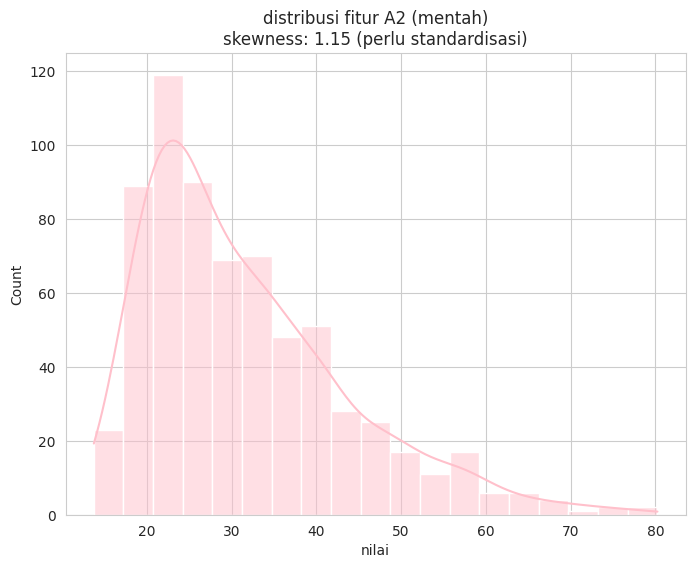

In [43]:
feature_name = 'A2'
feature_raw = X[feature_name].dropna()
skewness = feature_raw.skew()

plt.figure(figsize=(8, 6))
sns.histplot(feature_raw, kde=True, color='pink')
plt.title(f'distribusi fitur {feature_name} (mentah)\nskewness: {skewness:.2f} (perlu standardisasi)')
plt.xlabel('nilai')
plt.show()

**demonstrasi komparatif 3 scaler**

kode ini adalah demonstrasi langsung terhadap materi transformation dari ppt (slide 27-28).

1. demonstrasi: saya menerapkan tiga jenis scaler—standardscaler, minmaxscaler, dan robustscaler—pada fitur a2 yang telah diimputasi.

2. justifikasi visual: tiga plot density ditampilkan secara berdampingan untuk memperlihatkan efek unik dari masing-masing scaler:

* standardscaler memusatkan data di mean≈0.

* minmaxscaler memadatkan data dalam kisaran 0 hingga 1.

* robustscaler mempertahankan bentuk distribusi sambil menahan dampak dari outlier.

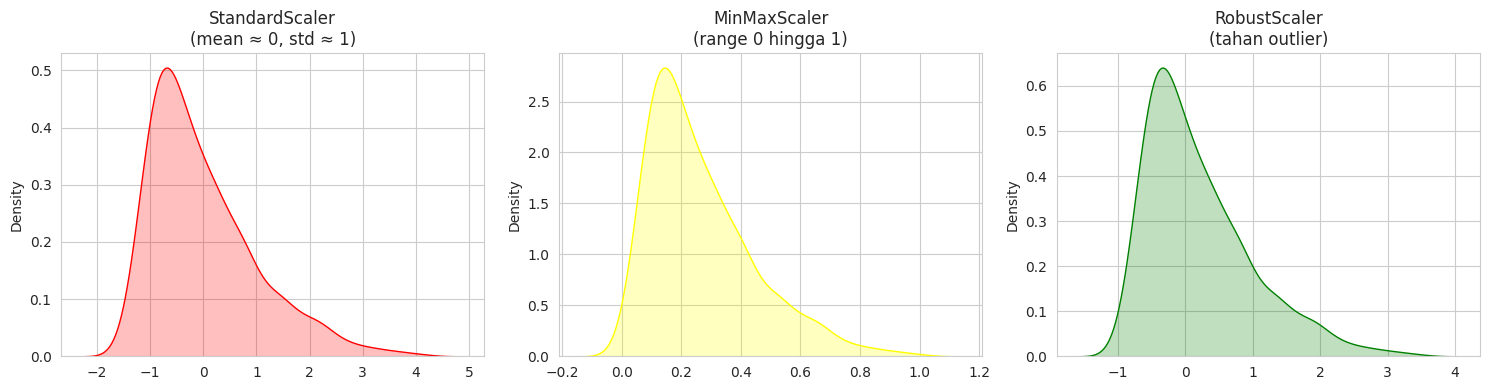

In [34]:
X_temp = numerical_pipeline.named_steps['imputer'].fit_transform(X[numerical_features])
X_temp_df = pd.DataFrame(X_temp, columns=numerical_features)
data_to_scale = X_temp_df['A2'].values.reshape(-1, 1)

data_standard = StandardScaler().fit_transform(data_to_scale)
data_minmax = MinMaxScaler().fit_transform(data_to_scale)
data_robust = RobustScaler().fit_transform(data_to_scale)


plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.kdeplot(data_standard.flatten(), fill=True, color='red')
plt.title('StandardScaler\n(mean ≈ 0, std ≈ 1)')

plt.subplot(1, 3, 2)
sns.kdeplot(data_minmax.flatten(), fill=True, color='yellow')
plt.title('MinMaxScaler\n(range 0 hingga 1)')

plt.subplot(1, 3, 3)
sns.kdeplot(data_robust.flatten(), fill=True, color='green')
plt.title('RobustScaler\n(tahan outlier)')

plt.tight_layout()
plt.show()

**verifikasi visual standarscaler**

kode ini berfungsi sebagai verifikasi visual akhir terhadap proses transformation yang dilakukan oleh standardscaler.

1. komparasi data: saya mengambil dua versi data fitur a2: data mentah (feature_a2_raw) dan data yang sudah tertransformasi oleh pipeline (feature_a2_scaled).

2. bukti fungsi: saya menampilkan kedua distribusi tersebut dalam dua plot density berdampingan.

3. tujuan: plot pertama menunjukkan bentuk distribusi aslinya, sementara plot kedua (data yang di-scaling) harus terpusat di nilai 0 di sumbu x. ini adalah bukti yang tidak terbantahkan bahwa standardscaler telah berhasil memindahkan mean data ke nol dan menstandardisasi standard deviation (sesuai prinsip standardscaler), menjadikan data siap untuk model data mining.


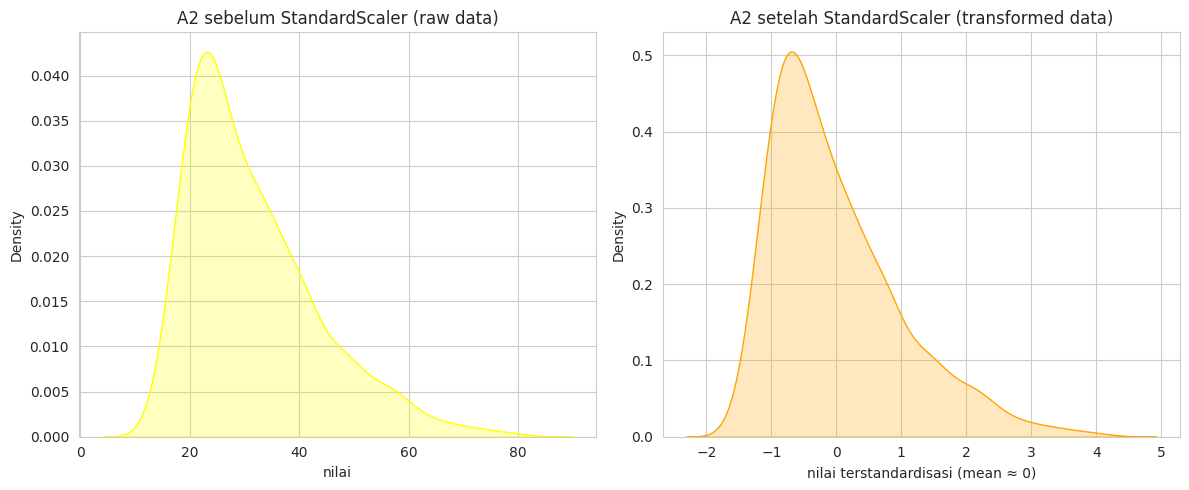

In [40]:
feature_A2_raw = X['A2'].dropna()
feature_A2_scaled = X_processed_df['A2']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.kdeplot(feature_A2_raw, fill=True, color='yellow')
plt.title(f'A2 sebelum StandardScaler (raw data)')
plt.xlabel('nilai')

plt.subplot(1, 2, 2)
sns.kdeplot(feature_A2_scaled, fill=True, color='orange')
plt.title(f'A2 setelah StandardScaler (transformed data)')
plt.xlabel('nilai terstandardisasi (mean ≈ 0)')

plt.tight_layout()
plt.show()

**verifikasi numerik dan data selection akhir**

kode ini adalah langkah penutup yang sangat penting sebelum data diserahkan ke model data mining. tujuannya ada dua:

1. verifikasi transformation: baris print(x_processed_df[...].describe().loc[['mean', 'std']]) berfungsi sebagai bukti numerik. jika standardscaler berhasil diterapkan, maka nilai mean (≈0) dan std (≈1) pada semua fitur numerik harus tercetak di layar. ini memvalidasi keberhasilan seluruh proses scaling di pipeline.

2. data selection akhir: fungsi train_test_split menjalankan tahap pemisahan data yang wajib. data yang sudah bersih dan terstandardisasi (x_processed_df) dibagi menjadi data training dan testing (dengan rasio 70:30).

pembagian ini memastikan model dapat dilatih pada satu set data dan diuji pada set data yang belum pernah dilihat, sesuai dengan metodologi data mining yang benar.


In [41]:
print(X_processed_df[numerical_features].describe().loc[['mean', 'std']])

X_train, X_test, y_train, y_test = train_test_split(
    X_processed_df, y, test_size=0.3, random_state=42
)

                A2            A3            A8           A11           A14  \
mean  2.111033e-16  2.059544e-17  8.238177e-17 -2.059544e-17  3.089316e-17   
std   1.000725e+00  1.000725e+00  1.000725e+00  1.000725e+00  1.000725e+00   

               A15  
mean -2.059544e-17  
std   1.000725e+00  
